# Excess mortality in Russia in 2023 due to the war in Ukraine
## Analysis published in Meduza in Jul 2023
https://meduza.io/feature/2023/07/10/47-tysyach-pogibshih-rossiyskih-soldat

In [1]:
%matplotlib notebook

import numpy as np
import pylab as plt
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression

In [2]:
df = pd.read_csv('../deaths-by-age-gender-region-year/deaths-by-age-gender-region-year-1990-2022.csv.gz')

df

,Region,Year,Age,Gender,Deaths
0,Алтайский край,1990,0-4 лет,f,264
1,Алтайский край,1990,0-4 лет,m,429
2,Алтайский край,1990,10-14 лет,f,28
3,Алтайский край,1990,10-14 лет,m,76
4,Алтайский край,1990,15-19 лет,f,63
...,...,...,...,...,...
112995,Ярославская область,2022,85 и более,m,807
112996,Ярославская область,2022,Всего,f,10264
112997,Ярославская область,2022,Всего,m,9202
112998,Ярославская область,2022,Неизвестно,f,1


<IPython.core.display.Javascript object>


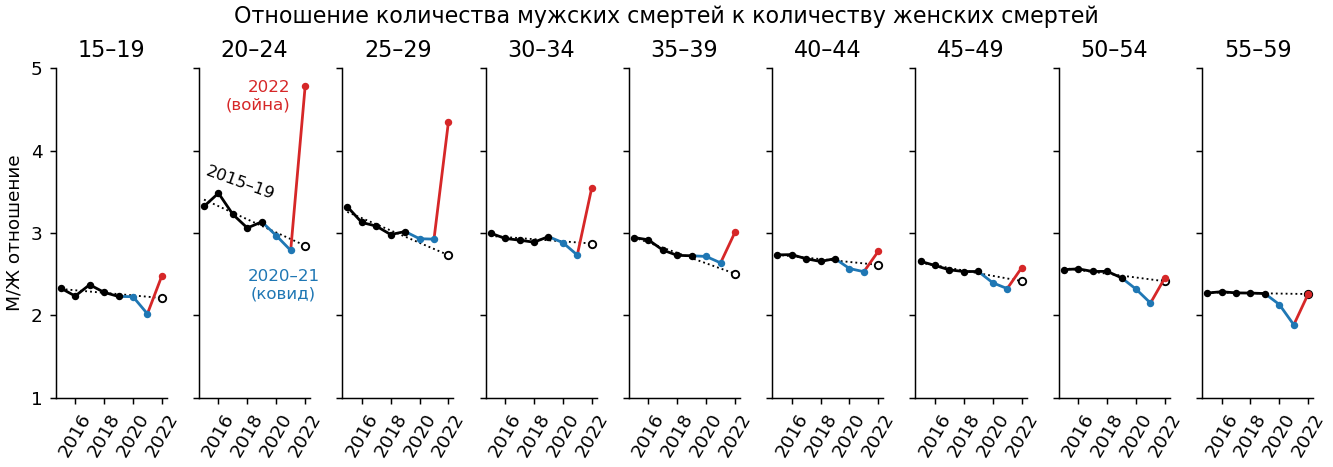

15-19 лет
Male deaths:    [3353 3005 2986 2829 2773 2813 2986 3260]
Female deaths:  [1439 1345 1259 1241 1244 1263 1479 1315]
Ratios:         [2.3 2.2 2.4 2.3 2.2 2.2 2.  2.5]
Fitted ratios:  [2.3 2.3 2.3 2.3 2.3 2.2 2.2 2.2]

20-24 лет
Male deaths:    [8633 7234 5971 5310 4994 4995 5052 7591]
Female deaths:  [2598 2077 1852 1735 1593 1683 1812 1589]
Ratios:         [3.3 3.5 3.2 3.1 3.1 3.  2.8 4.8]
Fitted ratios:  [3.4 3.3 3.2 3.2 3.1 3.  2.9 2.8]

25-29 лет
Male deaths:    [19532 16818 13959 11913 10056  9625  9187 10651]
Female deaths:  [5886 5378 4527 3997 3333 3285 3141 2450]
Ratios:         [3.3 3.1 3.1 3.  3.  2.9 2.9 4.3]
Fitted ratios:  [3.3 3.2 3.1 3.  3.  2.9 2.8 2.7]

30-34 лет
Male deaths:    [30766 28128 25135 23643 22520 23033 23190 22399]
Female deaths:  [10263  9589  8630  8187  7621  7990  8489  6315]
Ratios:         [3.  2.9 2.9 2.9 3.  2.9 2.7 3.5]
Fitted ratios:  [3.  3.  2.9 2.9 2.9 2.9 2.9 2.9]

35-39 лет
Male deaths:    [39320 37451 34168 33836 32593 35124 37139

In [8]:
region = 'Российская Федерация'

fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(10, 3.5), layout='constrained')

agegroups = ['15-19 лет', '20-24 лет', '25-29 лет',
       '30-34 лет', '35-39 лет', '40-44 лет', '45-49 лет', 
       '50-54 лет', '55-59 лет']

agegroups_shortened = [a[:2] + '–' + a[3:5] for a in agegroups]

LinReg = LinearRegression()

excess_male = []
excess_male_std = []

for i, age in enumerate(agegroups):
    ax = axs.flatten()[i]

    # Get the data
    male = df[
        (df.Region == region) & 
        (df.Age == age) & 
        (df.Gender == 'm') & 
        (df.Year >= 2015)
    ][['Year', 'Deaths']].values
    
    female = df[
        (df.Region == region) & 
        (df.Age == age) & 
        (df.Gender == 'f') & 
        (df.Year >= 2015)
    ][['Year', 'Deaths']].values
    
    ratio = male[:,1] / female[:,1]
    x = np.arange(2015, 2023)
    
    # Plot the ratios
    ax.plot(x[:-3], ratio[:-3], 'k.-')
    ax.plot(x[-4:-1], ratio[-4:-1], '-', color='tab:blue', zorder=-1)
    ax.plot(x[-3:-1], ratio[-3:-1], '.', color='tab:blue')
    ax.plot(x[-2:], ratio[-2:], '-', color='tab:red', zorder=-1)
    ax.plot(x[-1], ratio[-1], '.', color='tab:red')
    
    # Perform the linear fit and extrapolate        
    LinReg.fit(x[-8:-3].reshape(-1,1), ratio[-8:-3].reshape(-1,1))
    yhat = LinReg.predict(x[-8:].reshape(-1,1))
    ax.plot(x[-8:], yhat, ':', lw=1, color='k', zorder=-2)
    ax.plot(x[-1], yhat[-1], 'o', markersize=4, color='w', markeredgecolor='k', zorder=-2)
    
    excess_male.append(male[-1,1] - yhat[-1][0] * female[-1,1])
    
    # Compute the uncertainty
    X = np.concatenate((x[-8:].reshape(-1,1), np.ones((8,1))), axis=1)
    y = ratio[-8:].reshape(-1,1)
    beta = np.linalg.pinv(X[-8:-3].T @ X[-8:-3]) @ X[-8:-3].T @ y[-8:-3]
    yhat = X[-8:] @ beta
    sigma2 = np.sum((y[-8:-3] - yhat[-8:-3])**2) / (y.size - 2) # sigma^2 = MSE/(n-p)
    S = np.linalg.pinv(X[-8:-3].T @ X[-8:-3])
    predictive_var = sigma2 * X[-1:] @ S @ X[-1:].T + sigma2
    predictive_std = np.sqrt(predictive_var[0][0]) 
    excess_male_std.append(predictive_std * female[-1,1])

    # Take care of the plot
    ax.set_title(agegroups_shortened[i])
    ax.set_ylim([1,5])
        
    ax.set_xticks([2016, 2018, 2020, 2022])
    ax.set_xticklabels([2016, 2018, 2020, 2022], rotation=60)
    ax.set_yticks([1,2,3,4,5]) 
            
    if i == 0:
        ax.set_ylabel(r'М/Ж отношение')
    else:
        ax.set_yticklabels([])

    if i == 1:
        ax.text(2015, 3.4, '2015–19', fontsize=9, rotation=-20)
        ax.text(2020.5, 2.2, '2020–21\n(ковид)', fontsize=9, color='tab:blue', ha='center')
        ax.text(2021, 4.5, '2022\n(война)', fontsize=9, color='tab:red', ha='right')
        
    # Print the values
    print(age)
    print('Male deaths:   ', male[:,1].flatten())
    print('Female deaths: ', female[:,1].flatten())
    print('Ratios:        ', np.round(ratio, 1).flatten())
    print('Fitted ratios: ', np.round(yhat, 1).flatten())
    print('')
    
sns.despine()

fig.suptitle('Отношение количества мужских смертей к количеству женских смертей')

plt.savefig('figures/medusa-ratios.png', dpi=200)
plt.savefig('figures/medusa-ratios.svg')

In [15]:
# Final excess estimates by age group (with 95% CI)

for i in range(len(excess_male)):
    print(f'{agegroups[i]}:      {excess_male[i]:5.0f} +- {excess_male_std[i]*2:4.0f}')

total_std = np.sqrt(np.sum(np.array(excess_male_std)[:-2]**2))
    
print(f'\nTotal (15--49): {np.sum(excess_male[:-2]):5.0f} +- {total_std*2:4.0f}')

15-19 лет:        353 +-  233
20-24 лет:       3069 +-  532
25-29 лет:       3961 +-  448
30-34 лет:       4264 +-  724
35-39 лет:       6047 +- 1126
40-44 лет:       2692 +- 1116
45-49 лет:       3209 +- 1157
50-54 лет:        990 +- 1682
55-59 лет:         83 +-  753

Total (15--49): 23594 +- 2217
